# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler
import plotter
import utils

import matplotlib.pyplot as plt
import matplotlib.pyplot
import matplotlib.dates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
import scipy.stats


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)


Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


# Methods


In [5]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    dataframe["complied"] = np.nan
    # Define the criteria for response times
    criteria = {
        ('A', True): 12 * 60,
        ('A', False): 25 * 60,
        ('H', True): 30 * 60,
        ('H', False): 40 * 60
    }

    for (triage, urban), group in dataframe.groupby(['triage_impression_during_call', 'urban_settlement_ssb']):
        limit = criteria.get((triage, urban))
        if limit is not None:
            dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit

    return dataframe


In [6]:
def plot_time_distribution(dataframe: pd.DataFrame):
    # Extract hours, minutes, and seconds
    dataframe['hour'] = dataframe['time_call_received'].dt.hour
    dataframe['minute'] = dataframe['time_call_received'].dt.minute
    dataframe['second'] = dataframe['time_call_received'].dt.second

    # Set up the figure and axes
    fig = plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)  # Hour plot
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)  # Minute plot
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)  # Second plot
    ax_legend = plt.subplot2grid((2, 2), (0, 1), colspan=2, rowspan=2)  # Legend plot

    triage_to_name = {
        "A": "Acute",
        "H": "Urgent",
        "V1": "Non-Urgent"
    }

    # Time components and axes
    time_components = ['hour', 'minute', 'second']
    axs = [ax1, ax2, ax3]
    titles = ["Hour", "Minute", "Second"]

    lines = []  # To store line handles for the legend
    labels = []  # To store labels for the legend

    for ax, component in zip(axs, time_components):
        # For each category in triage impressions
        for category in ["A", "H", "V1"]:
            # Filter data by triage impression and calculate normalized count
            subset = dataframe[dataframe['triage_impression_during_call'] == category]
            count_series = subset[component].value_counts(normalize=True).sort_index()

            # Plot and collect line handles and labels for legend
            line, = ax.plot(count_series.index, count_series.values, marker='o')
            if len(labels) < 3:
                lines.append(line)
                labels.append(f"{triage_to_name[category]}")

        # Set title, labels
        ax.set_title(f"Probability Distribution of {titles[time_components.index(component)]}", fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
        ax.set_xlabel(titles[time_components.index(component)])
        if component != "second":
            ax.set_ylabel("Probability")
        
        # Set xticks appropriately
        if component == 'hour':
            ax.set_xticks(range(0, 24))
            ax.set_xlim((0, 23))
        else:
            ax.set_xticks(range(0, 60, 5))
            ax.set_xlim((0, 59))
            ax.set_ylim(top=0.025)
        
        ax.set_ylim(bottom=0)

    # Configure legend plot
    ax_legend.axis('off')
    ax_legend.legend(lines, labels, loc='upper right', title="Triage Impression")

    title = "Probability Distribution of Emergency Call by Triage Impression"

    fig.suptitle(title, **constants.FONT_PROPERTIES_HEADER)

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title.replace("\n", " ") + ".png"), dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()


# Main

In [7]:
dataframe = data_loader.enhanced_incidents_df.copy(deep=True)
dataframe = add_info(dataframe)


C:\Users\sindr\AppData\Local\Temp\ipykernel_2796\1518890614.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[group.index, 'complied'] = group['total_response_time'] < limit


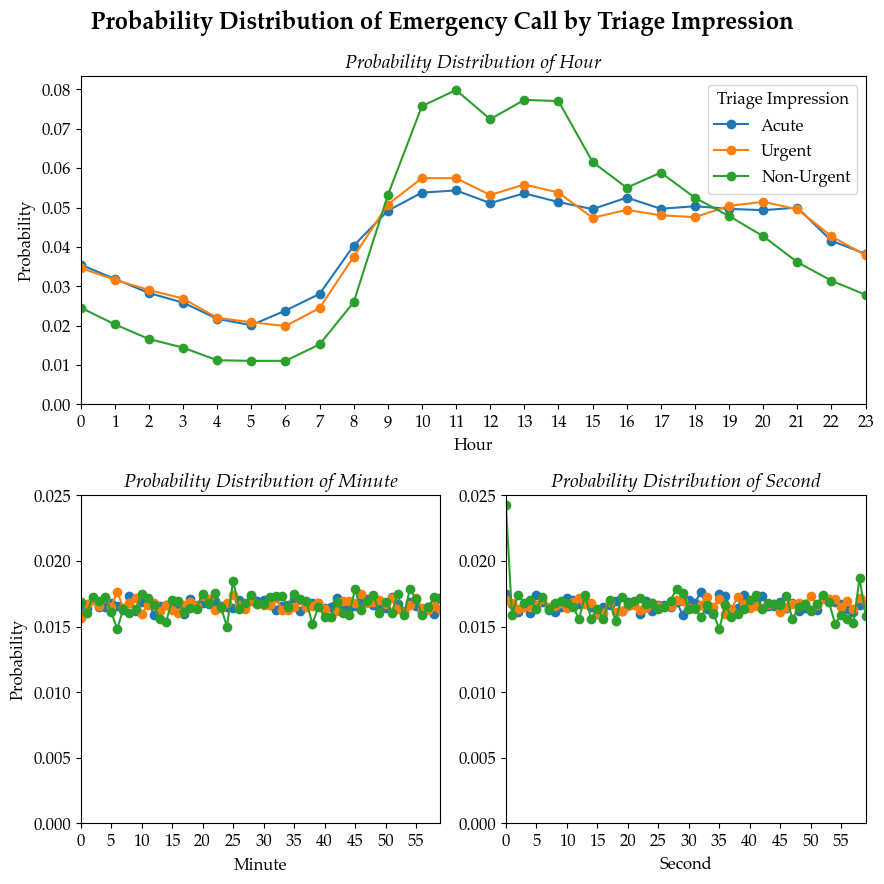

In [8]:
plot_time_distribution(dataframe)
